# Denoising diffusion probabilistic model

In the denoising diffusion probabilistic model, the authors used a U-Net architecture to predict the noise in the diffusion process. In this section, we implement and train a u-net based diffusion model on MNIST and CIFAR10 data. For the U-Net, we follow the architecture shown in Figure 1. 

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Diffusion/figures/unet.png" style="max-width: 55%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 1 </strong>: U-Net architecture for diffusion model.
</p>

The main components in the U-Net model are

* Double convolution
* Down block
* Up block

The architecture of these component is shown in the figure below. For the attention used in the U-Net model, we applied layer normalization to the typical self attention layer. 

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Diffusion/figures/component.png" style="max-width: 65%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 2 </strong>: Architecture of double convolution, down block and up block in U-Net.
</p>


## DDPM Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])


mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=mnist_transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32,
                                          shuffle=True)

cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=32,
                                          shuffle=True)

### U-Net Components Implementation

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, n_heads):
        super(SelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(in_channels, n_heads, batch_first=True)
        self.layernorm = nn.LayerNorm([in_channels])

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).view(B, H*W, C)
        x = self.layernorm(x)
        attn, _ = self.attention(x, x, x)
        x = (x + attn).view(B, H, W, C).permute(0, 3, 1, 2)
        return x

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, residual=False):
        super(DoubleConv2d, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1, bias=False),
                                 nn.GroupNorm(1, hidden_channels),
                                 nn.GELU(),
                                 nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                 nn.GroupNorm(1, out_channels))
        self.residual = residual
    
    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.net(x))
        return self.net(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super(DownBlock, self).__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2),
                                 DoubleConv2d(in_channels, in_channels, in_channels, residual=True),
                                 DoubleConv2d(in_channels, out_channels, out_channels))
        self.resize = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_dim, out_channels))

    def forward(self, x, t):
        x = self.net(x)
        t = self.resize(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + t

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super(UpBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.net = nn.Sequential(DoubleConv2d(in_channels, in_channels, in_channels, residual=True),
                                 DoubleConv2d(in_channels, in_channels // 2, out_channels))
        self.resize = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embed_dim, out_channels))

    def forward(self, x, x_skip, t):
        x = self.upsample(x)
        x = torch.cat([x_skip, x], dim=1)
        x = self.net(x)
        t = self.resize(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + t

def timestep_embedding(timesteps, dim, max_period=10000):
    half_dim = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(0, half_dim, dtype=torch.float32, device=DEVICE) / half_dim)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

### U-Net Implementation

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels, embed_dim, n_heads, timesteps, device="cpu"):
        super(UNet, self).__init__()
        self.in_conv = DoubleConv2d(in_channels, 64, 64)
        self.down1 = DownBlock(64, 128, embed_dim)
        self.down2 = DownBlock(128, 256, embed_dim)
        self.down3 = DownBlock(256, 256, embed_dim)
        self.down_attn1 = SelfAttention(128, n_heads)
        self.down_attn2 = SelfAttention(256, n_heads)
        self.down_attn3 = SelfAttention(256, n_heads)

        self.bottleneck1 = DoubleConv2d(256, 512, 512)
        self.bottleneck2 = DoubleConv2d(512, 512, 512)
        self.bottleneck3 = DoubleConv2d(512, 256, 256)

        self.up3 = UpBlock(512, 128, embed_dim)
        self.up2 = UpBlock(256, 64, embed_dim)
        self.up1 = UpBlock(128, 64, embed_dim)
        self.up_attn3 = SelfAttention(128, n_heads)
        self.up_attn2 = SelfAttention(64, n_heads)
        self.up_attn1 = SelfAttention(64, n_heads)
        self.out_conv = nn.Conv2d(64, in_channels, kernel_size=1)
        self.embed_dim = embed_dim
        self.timesteps = timesteps
        self.device = device

    def forward(self, x, t):
        t = timestep_embedding(t, self.embed_dim)
        ## Prepare for downsample path
        x0 = self.in_conv(x)

        ## Start downsampling
        x1 = self.down_attn1(self.down1(x0, t))
        x2 = self.down_attn2(self.down2(x1, t))
        x3 = self.down_attn3(self.down3(x2, t))

        ## Bottleneck
        x3 = self.bottleneck1(x3)
        x3 = self.bottleneck2(x3)
        x3 = self.bottleneck3(x3)
        
        ## Upsample
        x2 = self.up_attn3(self.up3(x3, x2, t))
        x1 = self.up_attn2(self.up2(x2, x1, t))
        x0 = self.up_attn1(self.up1(x1, x0, t))
        x0 = self.out_conv(x0)
        return x0

### Diffusion Model Implementation

In [4]:
class Diffusion(nn.Module):

    def __init__(self, in_channels, embed_dim, n_heads, img_size, timesteps, beta_min, beta_max, device="cpu"):
        super(Diffusion, self).__init__()
        self.unet = UNet(in_channels, embed_dim, n_heads, timesteps, device=device)
        
        self.beta = torch.linspace(beta_min, beta_max, timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_ = torch.cumprod(self.alpha, dim=0)
        
        self.img_size = img_size
        self.in_channels = in_channels
        self.timesteps = timesteps
        self.device = device

    def forward(self, x, t):
        noise = torch.randn_like(x, device=self.device).to(self.device)
        noised_x = torch.sqrt(self.alpha_[t])[:, None, None, None] * x + torch.sqrt(1 - self.alpha_[t])[:, None, None, None] * noise
        return noised_x, noise

    def sample(self, n_samples):
        self.unet.eval()
        with torch.no_grad():
            x = torch.randn(n_samples, self.in_channels, self.img_size, self.img_size).to(self.device)
            for t in reversed(range(1, self.timesteps)):
                time = (t * torch.ones(n_samples, device=self.device)).long()
                pred_noise = self.unet(x, time)
                alpha, alpha_, beta = self.alpha[time], self.alpha_[time], self.beta[time]
                alpha = alpha[:, None, None, None]
                alpha_ = alpha_[:, None, None, None]
                beta = beta[:, None, None, None]
                noise = torch.randn(x.shape) if t > 1 else torch.zeros_like(x)
                noise = noise.to(self.device)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_))) * pred_noise) + torch.sqrt(beta) * noise
        self.unet.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

## MNIST

We trained a diffusion model with an embedding dimension of $256$ and $4$ attention heads. The number of timesteps $T$ was set to $1000$, and the variance schedule followed a linear path from $10^{-4}$ to $0.02$. The model was trained for $10$ epochs with a learning rate of $10^{-4}$. The generated image is shown below.

In [6]:
model = Diffusion(in_channels=1, embed_dim=256, n_heads=4, img_size=32, timesteps=1000, beta_min=1e-4, beta_max=0.02, device=DEVICE)
model.to(DEVICE)
optimizer = optim.Adam(model.unet.parameters(), lr=1e-4)
train(model, mnist_trainloader, optimizer, 10, device=DEVICE)

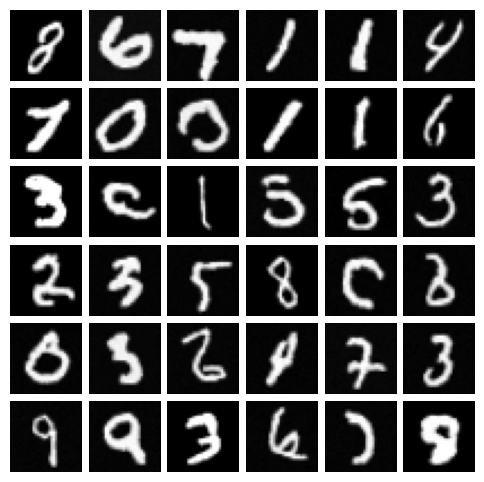

In [9]:
plot_samples(n_samples=36)

## CIFAR10

We also trained a diffusion model with the same architecture and hyperparameter settings on CIFAR-10. This time, the model was trained for $30$ epochs. The generated image is shown below.

In [ ]:
model = Diffusion(in_channels=3, embed_dim=256, n_heads=4, img_size=32, timesteps=1000, beta_min=1e-4, beta_max=0.02, device=DEVICE)
model.to(DEVICE)
optimizer = optim.Adam(model.unet.parameters(), lr=1e-4)
train(model, cifar_trainloader, optimizer, 10, device=DEVICE)

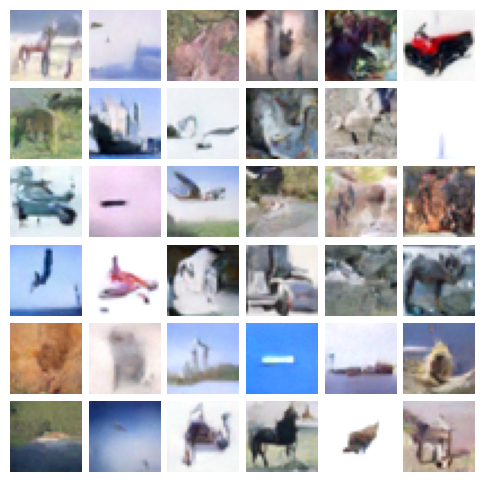

In [12]:
plot_samples(n_samples=36)